In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import os
import json
import numpy as np
import random
from tqdm.notebook import tqdm
from torchvision.transforms import functional as FN
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchsummary import summary
from torch.utils.data._utils.collate import default_collate
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset

from time import time
from IPython.display import clear_output

In [2]:
class PotholeDataset(Dataset):
    def __init__(self, json_file, transform=None, target_transform=None, subset=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        self.transform = transform
        self.target_transform = target_transform
        self.subset = subset
        self.cropped_data = []
        self.prepare_dataset()

        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),  # Rotate by ±20 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            self.random_noise
        ])

    def random_noise(self, img):
        if random.random() < 0.5:  # 50% chance to add noise
            noise = torch.randn(img.size()) * 0.05
            img = img + noise
            img = torch.clamp(img, 0, 1)
        return img

    def prepare_dataset(self):
        for item in self.data:
            if self.subset is not None and item.get('subset') != self.subset:
                continue
            image_path = item['image']
            image = Image.open(image_path).convert('RGB')
            for box_info in item['boxes']:
                box = box_info['box']
                label = box_info['label']
                cropped_image = FN.crop(image, box[1], box[0], box[3], box[2])  # top, left, height, width
                if self.transform:
                    cropped_image = self.transform(cropped_image)
                self.cropped_data.append((cropped_image, label))

    def __len__(self):
        return len(self.cropped_data)

    def __getitem__(self, idx):
        image, label = self.cropped_data[idx]


        # Check if the label is positive (1), and apply augmentations if so
        if label == 1:
            image = self.augment_transform(image)

        return image, label

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
with open('processed_images_data.json', 'r') as file:
    data = json.load(file)

count_negative_class_samples = 0
count_positive_class_samples = 0

# Iterate through the data and count the labels
for entry in data:
    for box in entry['boxes']:
        if box['label'] == 0:
            count_negative_class_samples += 1
        elif box['label'] == 1:
            count_positive_class_samples += 1

print("Negative class samples count:", count_negative_class_samples)
print("Positive class samples count:", count_positive_class_samples)

Negative class samples count: 61979
Positive class samples count: 757


In [16]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the cropped images
    transforms.ToTensor()
])

train_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='train')

# Separate indices for negative and positive class samples
negative_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
positive_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]

# Randomly downsample negative class
random.shuffle(negative_indices)
downsampled_negative_indices = negative_indices[:len(positive_indices)]

# Combine positive and downsampled negative indices
balanced_indices = downsampled_negative_indices + positive_indices
random.shuffle(balanced_indices)  # Shuffle to mix positive and negative samples

# Create a subset of the dataset using the balanced indices
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# DataLoader using the balanced dataset
train_loader = DataLoader(balanced_train_dataset, batch_size=4, shuffle=True, num_workers=3)

test_dataset = PotholeDataset(json_file='processed_images_data.json', transform=transform, subset='test')
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=3)

In [13]:
images, labels = next(iter(test_loader))
print (len(images))
plt.figure(figsize=(20,10))

count = 0
count_b = 0
# Assuming 'labels' is a tensor containing the labels for the images
for minibatch_no, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
    
# Count the number of labels that are equal to 1
    count += (target == 1).sum().item()
    count_b += (target == 0).sum().item()
# Printing the count
print("Number of labels equal to 1:", count)
print("Number of labels equal to 0:", count_b)


64


  0%|          | 0/98 [00:00<?, ?it/s]

Number of labels equal to 1: 80
Number of labels equal to 0: 6180


<Figure size 2000x1000 with 0 Axes>

In [12]:
images, labels = next(iter(train_loader))
print (len(images))
plt.figure(figsize=(20,10))

count = 0
count_b = 0
# Assuming 'labels' is a tensor containing the labels for the images
for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
    
# Count the number of labels that are equal to 1
    count += (target == 1).sum().item()
    count_b += (target == 0).sum().item()
# Printing the count
print("Number of labels equal to 1:", count)
print("Number of labels equal to 0:", count_b)

64


  0%|          | 0/19 [00:00<?, ?it/s]

Number of labels equal to 1: 583
Number of labels equal to 0: 583


<Figure size 2000x1000 with 0 Axes>

64


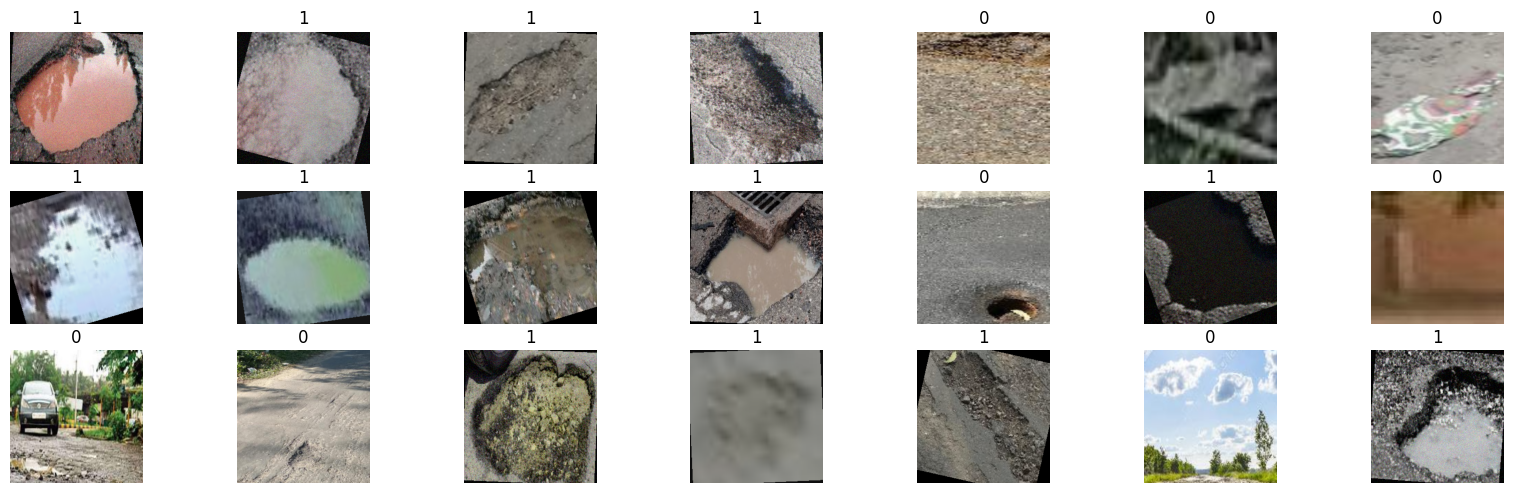

In [7]:
images, labels = next(iter(train_loader))
print (len(images))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['0', '1'][labels[i].item()])
    plt.axis('off')


In [27]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = nn.CrossEntropyLoss()(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(nn.CrossEntropyLoss()(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(balanced_train_dataset ))
        out_dict['test_acc'].append(test_correct/len(test_dataset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [28]:
model_ft = models.resnet50()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_adam = torch.optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.01)
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
out_dict = train(model_ft, optimizer_adam, num_epochs=3)

  0%|          | 0/3 [00:00<?, ?epoch/s]

  0%|          | 0/292 [00:00<?, ?it/s]

Loss train: 0.435	 test: 0.163	 Accuracy train: 80.8%	 test: 95.1%


  0%|          | 0/292 [00:00<?, ?it/s]

Loss train: 0.197	 test: 0.289	 Accuracy train: 94.0%	 test: 95.2%


  0%|          | 0/292 [00:00<?, ?it/s]

Loss train: 0.114	 test: 0.045	 Accuracy train: 96.6%	 test: 99.0%


In [30]:
images, labels = next(iter(train_loader))
images = images.to(device)
pred= model_ft(images)

In [31]:
print(pred)
print(labels)

tensor([[-0.6997,  0.9761],
        [ 2.1736, -1.5204],
        [-1.2491,  1.7082],
        [ 4.9534, -3.1392]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0])



Misclassified Example 809:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.82623875 0.17376126]]


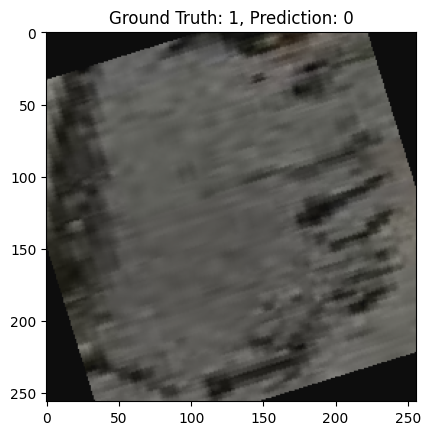


Misclassified Example 1481:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.938417   0.06158298]]


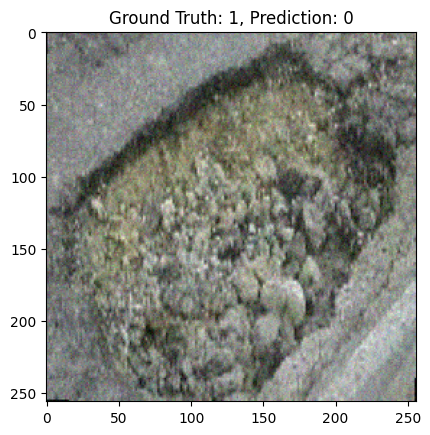

IndexError: list index out of range

In [35]:
c = 0
with torch.no_grad():
    for i in range(len(test_loader.dataset)):
        example_data, example_target = test_loader.dataset[i+int(len(test_loader.dataset)/2)]
        example_data = example_data.unsqueeze(0).to(device)  # Add batch dimension
        example_output = model_ft(example_data)

        if example_target != example_output.argmax().item() and example_target==1:
            c += 1
            print(f"\nMisclassified Example {i + 1}:")
            print("Ground Truth:", example_target)
            print("Model Prediction:", example_output.argmax().item())
            print("Model Probabilities:", torch.softmax(example_output, dim=1).cpu().numpy())

            # Display the associated MNIST image
            plt.imshow(example_data.squeeze().permute(1, 2, 0).cpu().numpy())
            plt.title(f"Ground Truth: {example_target}, Prediction: {example_output.argmax().item()}")
            plt.show()
        if c > 5:
            break

In [60]:
class PotholeDataset2(Dataset):
    def __init__(self, json_file, transform=None, target_transform=None, subset=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        self.transform = transform
        self.target_transform = target_transform
        self.subset = subset
        self.cropped_data = []
        self.prepare_dataset()


    def prepare_dataset(self):
        for item in self.data:
            if self.subset is not None and item.get('subset') != self.subset:
                continue
            image_path = item['image']
            image = Image.open(image_path).convert('RGB')
            for box_info in item['boxes']:
                box = box_info['box']
                label = image_path
                cropped_image = FN.crop(image, box[1], box[0], box[3], box[2])  # top, left, height, width
                if self.transform:
                    cropped_image = self.transform(cropped_image)
                self.cropped_data.append((cropped_image, label, box))

    def __len__(self):
        return len(self.cropped_data)

    def __getitem__(self, idx):
        image, label, boundingboxes = self.cropped_data[idx]



        return image, label, boundingboxes

In [61]:



picture_boxes = PotholeDataset2(json_file='processed_images_data.json', transform=transform, subset='test')
picture_loader = DataLoader(picture_boxes, batch_size=1, shuffle=False, num_workers=3)

In [69]:
images, labels, box = next(iter(picture_loader))
images = images.to(device)
pred= model_ft(images)


In [70]:
pred

tensor([[ 0.1940, -0.5222]], device='cuda:0', grad_fn=<AddmmBackward0>)

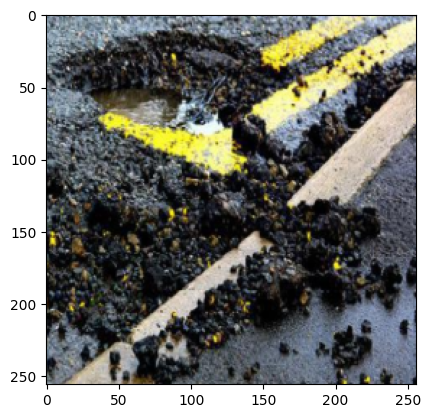

In [71]:
plt.imshow(images[0].squeeze().permute(1, 2, 0).cpu().numpy())


In [72]:
labels

('Potholes/annotated-images/img-639.jpg',)

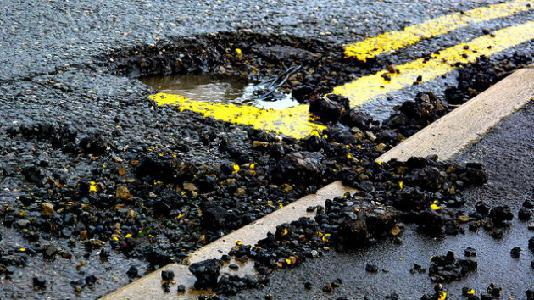

In [74]:
Image.open(labels[0]).convert('RGB')


In [114]:
# Function to display image with bounding boxes
print(box)
def display_image_with_boxes(image_path=labels[0], boxes=box):
    # Open the image file
    img = Image.open(image_path)
    # Create a figure and axis for the image
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(img)
    
    # Add the bounding boxes
    xmin, ymin, xmax, ymax = boxes
        # Create a Rectangle patch
    prop = torch.softmax(pred, dim=1).cpu().detach().numpy()[0][1]
    print(prop)
    if pred.argmax().item() == 1:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
        ax.annotate(f'Prediction: 1, Probability: {prop:.2f}', (xmin, ymin), color='green', weight='bold')

    else:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.annotate(f'Prediction: 0, Probability: {1-prop:.2f}', (xmin, ymin), color='red', weight='bold')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()


[tensor([85]), tensor([19]), tensor([445]), tensor([276])]


0.32822707


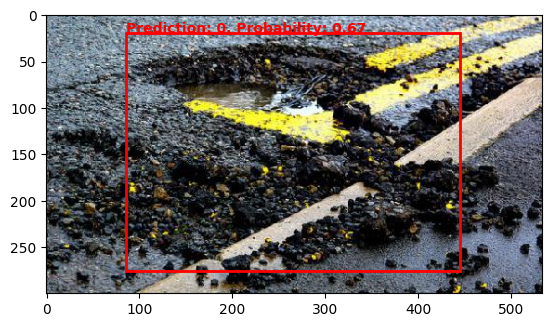

In [115]:
display_image_with_boxes()

In [116]:
torch.save(model_ft.state_dict(),"whatever.pt")